In [221]:
# setting environment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings("ignore")

This is a Data Science practice problem I found on [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/all/practice?)

### Description
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

### Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

The data contains training set and testing set, training set has all the features and outcomes while testing set has only features, we will use the training set only to tune our model before submitting it online to run the real test data.

In [222]:
# reading csv file
data = pd.read_csv('data/Train.csv')

In [223]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Exploratory Data Analysis
We will first examine the composition of each columns and determine how to deal with it

In [224]:
# check the shape of data we have
data.shape

(614, 13)

In [225]:
# check the data type of each feature
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [226]:
# check the unique values of the categorical variables
cat = data.select_dtypes(include=['object'])
cat.nunique()

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

In [227]:
# check the null value in each column
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [228]:
# check Gender column
data['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [229]:
# check Married column
data['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [230]:
# check Dependents column
data['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [231]:
# check Self_Employed column
data['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64


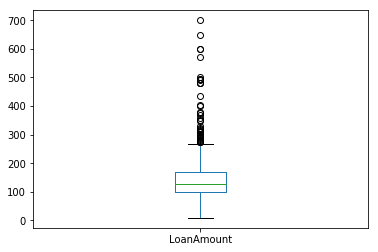

In [232]:
# check LoanAmount column
print(data['LoanAmount'].describe())
data['LoanAmount'].plot(kind='box')
plt.show()

In [233]:
# check Loan_Amount_Term column
data['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [234]:
# check Credit_History column
data['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [235]:
# we first plot the difference in each numeric column between group that get loan approval and group that did not
data.groupby(['Loan_Status']).mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,
N,5446.078125,1877.807292,151.220994,344.064516,0.541899
Y,5384.068720,1504.516398,144.294404,341.072464,0.981818


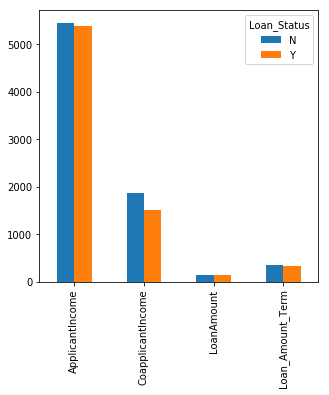

In [236]:
# we will deal with credit history column separately since its value is a lot lower than the others
data.groupby(['Loan_Status']).mean().drop(['Credit_History'], axis=1).transpose().plot(kind='bar', figsize=(5,5))
plt.show()

From the graph above, we can see that applicant income mean value is pretty much the same between group that got loan approval and group that did not, in contrast, coapplicant income result is a little bit counter ituitive, the group that got loan approval actually has lower coapplicant income value, there could be a chance that most applicant does not actually have co-applicants when applying loans and has a 0 value in that column, we can combine both to make a total income feature to and analyze together

In [237]:
# creating new feature total income
data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']

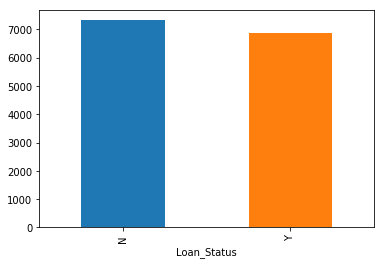

In [238]:
data.groupby(['Loan_Status']).mean()['Total_Income'].plot(kind='bar')
plt.show()

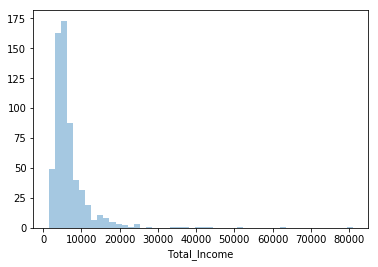

In [239]:
# plot the distribution of total income
sns.distplot(data['Total_Income'], kde=False)
plt.show()

We can see that the variable is right skewed, we will use the log transform to make it more normal distribution since this can make the cost fucntion minimize better the error of the predictions and to make the algorithm converge properly and faster

In [240]:
# tranform the data to normal distribution-like
data['Total_Income'] = np.log(data['Total_Income'])

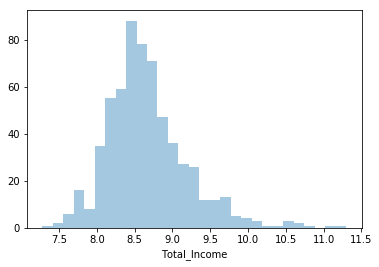

In [241]:
# replot to confirm
sns.distplot(data['Total_Income'], kde=False)
plt.show()

First of all, we split the dataset into training and testing and do all the processing, feature engineering, transformation on training set only without taking any peek of the testing set

In [242]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('Loan_Status', axis=1), data['Loan_Status']
                                                    ,test_size=0.3, random_state=1009, stratify=data['Loan_Status'])

In [243]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429 entries, 228 to 398
Data columns (total 13 columns):
Loan_ID              429 non-null object
Gender               421 non-null object
Married              427 non-null object
Dependents           419 non-null object
Education            429 non-null object
Self_Employed        404 non-null object
ApplicantIncome      429 non-null int64
CoapplicantIncome    429 non-null float64
LoanAmount           414 non-null float64
Loan_Amount_Term     420 non-null float64
Credit_History       395 non-null float64
Property_Area        429 non-null object
Total_Income         429 non-null float64
dtypes: float64(5), int64(1), object(7)
memory usage: 46.9+ KB


In [244]:
# build up custom category imputers to deal with categorical features
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='most_frequent'):
        self.cols = cols
        self.strategy = strategy
    def transform(self, df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]]) # remember double bracket
        return X
    def fit(self, *_):
        return self
    
class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
    def transform(self, df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    def fit(self, *_):
        return self

        

In [245]:
# deal with categorical variables and impute missing values with mode
# istantiate the Imputer
cat_cols = ['Gender', 'Married', 'Self_Employed', 'Loan_Amount_Term', 'Dependents', 'Credit_History']
cci = CustomCategoryImputer(cols=cat_cols)
X_train = cci.fit_transform(X_train)

In [246]:
# deal with numerical variables and impute missing values with median
cqi = CustomQuantitativeImputer(cols=['LoanAmount'], strategy='median')
X_train = cqi.fit_transform(X_train)

In [247]:
# check the result
X_train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Total_Income         0
dtype: int64

In [248]:
# define a function to deal with extra feature engineering
def feature_eng(df):
    # deal with Dependents variable
    df['Dependents'] = df['Dependents'].str.replace('3+', '3', regex=False)
    df['Dependents'] = pd.to_numeric(df['Dependents'])
    # construct Total_Income column
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    # construct leverage column
    df['leverage'] = df['LoanAmount'] / df['Total_Income']
    # transform LoanAmount column into more normal distribution
    df['LoanAmount'] = df['LoanAmount']**0.3
    # drop Loan_ID column
    df.drop(['Loan_ID'], axis=1, inplace=True)
    return df

In [249]:
X_train = feature_eng(X_train)

In [250]:
# define custom dummifier to deal with categorical variable
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, X):
        return pd.get_dummies(X)
    def fit(self, *_):
        return self

In [251]:
dum = CustomDummifier()
X_train = dum.fit_transform(X_train)

In [252]:
X_train.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,leverage,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
228,0,4758,0.0,4.566644,480.0,1.0,4758.0,0.033207,0,1,0,1,1,0,1,0,0,1,0
493,0,17263,0.0,5.077556,360.0,1.0,17263.0,0.013034,1,0,1,0,0,1,0,1,0,1,0
248,1,2882,1843.0,4.236152,480.0,1.0,4725.0,0.026032,0,1,0,1,1,0,1,0,0,1,0
519,0,3400,0.0,3.920280,360.0,1.0,3400.0,0.027941,1,0,1,0,0,1,1,0,1,0,0
510,0,3598,1287.0,3.981072,360.0,1.0,4885.0,0.020471,0,1,1,0,0,1,1,0,1,0,0


In [253]:
# creating pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline(
                [('category', cci),
                 ('quantity', cqi)
                 ])

We will fit the vanilla logistic regression first

In [254]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lg = LogisticRegression()
cross_val_score(lg, X_train, y_train, cv=10)

array([0.72727273, 0.75      , 0.93181818, 0.75      , 0.76744186,
       0.85714286, 0.85714286, 0.85714286, 0.83333333, 0.88095238])

We can see that the score varies quite a bit, suggesting there might be some overfitting problem, we will start to fit our next model, ridge regression

In [255]:
# C is the inverse of regularization parameter
lg_ridge = LogisticRegression(penalty='l2', C=10)
lg_ridge.fit(X_train, y_train)
cross_val_score(lg_ridge, X_train, y_train, cv=10)

array([0.72727273, 0.75      , 0.93181818, 0.75      , 0.74418605,
       0.85714286, 0.85714286, 0.85714286, 0.83333333, 0.85714286])

Looks like the ridge regression model performs the same as the vanilla linear regression, we will try the lasso regression to see how it performs

In [256]:
# C is the inverse of regularization parameter
lg_lasso = LogisticRegression(penalty='l1', C=0.1)
lg_lasso.fit(X_train, y_train)
cross_val_score(lg_lasso, X_train, y_train, cv=10)

array([0.72727273, 0.75      , 0.93181818, 0.75      , 0.76744186,
       0.85714286, 0.85714286, 0.85714286, 0.83333333, 0.88095238])

In [257]:
# finally, we use GridsearchCV to find the best parameters of LogisticRegression
from sklearn.model_selection import GridSearchCV
params = {'penalty':['l1', 'l2'],
          'C': [0.001,0.01,0.1,1,10,100,1000],
          'fit_intercept': [True, False]}
lgr = LogisticRegression(random_state=1009)
grid = GridSearchCV(lgr, param_grid=params, cv=10)
grid.fit(X_train, y_train)
print('Best parameters: {}'.format(grid.best_params_))
print('Best scores: {}'.format(grid.best_score_))

Best parameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1'}
Best scores: 0.8205128205128205


Finally, we are ready to test the performance on our test set, we will perform the pre-processing we did on train set first

In [258]:
# preprocessing for test set
# feed in pipeline
X_test = pipe.transform(X_test)
# feature engineering
X_test = feature_eng(X_test)
# deal with dummy variables
X_test = dum.transform(X_test)

In [261]:
# fit the model and test the performance
lgr = LogisticRegression(**grid.best_params_, random_state=1009)
lgr.fit(X_train, y_train)
print('Performance: {}'.format(lgr.score(X_test, y_test)))

Performance: 0.8
